# Classifier test run using Tensorflow
https://datagen.tech/guides/image-classification/python/

In [1]:
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten,Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
import numpy as np
import pandas as pd
import os
import cv2
import matplotlib.pyplot as plt

2023-04-24 00:03:26.168822: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-24 00:03:26.170216: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-24 00:03:26.197947: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-24 00:03:26.198403: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-24 00:03:26.763150: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

## Image pre-processing
- VGG-19 model on custom dataset to classify three categories
- Pre-trained CNN model takes color image of 224 x 224 of one of the three
- Need to resize the images

### Deriving some things
- x_train: Numpy arrays of the images of the training dataset
- y_train: Labels of the training dataset
- x_test: Numpy arrays of the images of the testing dataset
- y_test: Labels of the testing dataset
- x_val: Numpy arrays of the images of the validation dataset
- y_val: Labels of the validation dataset

In [3]:
train_path="final-dataset/train"
test_path="final-dataset/test"
val_path="final-dataset/val"
x_train=[]

for folder in os.listdir(train_path):

    sub_path=train_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(224,224))

        x_train.append(img_arr)

x_test=[]

for folder in os.listdir(test_path):

    sub_path=test_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(224,224))

        x_test.append(img_arr)

x_val=[]

for folder in os.listdir(val_path):

    sub_path=val_path+"/"+folder

    for img in os.listdir(sub_path):

        image_path=sub_path+"/"+img

        img_arr=cv2.imread(image_path)

        img_arr=cv2.resize(img_arr,(224,224))

        x_val.append(img_arr)

- normalizing x_test, x_train, and x_val

In [4]:
train_x=np.array(x_train)
test_x=np.array(x_test)
val_x=np.array(x_val)
train_x=train_x/255.0
test_x=test_x/255.0
val_x=val_x/255.0

- computing the labels of corresponding datasets via ImageDataGenerator

In [5]:
train_datagen = ImageDataGenerator(rescale = 1./255)
test_datagen = ImageDataGenerator(rescale = 1./255)
val_datagen = ImageDataGenerator(rescale = 1./255)
training_set = train_datagen.flow_from_directory(train_path,
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'sparse')
test_set = test_datagen.flow_from_directory(test_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')
val_set = val_datagen.flow_from_directory(val_path,
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'sparse')

Found 60 images belonging to 3 classes.
Found 6 images belonging to 3 classes.
Found 12 images belonging to 3 classes.


- test = 0.2 * total
- train = 0.8 * total
- val = 0.2 * train

In [6]:
train_y=training_set.classes
test_y=test_set.classes
val_y=val_set.classes

- observe encoding

In [7]:
training_set.class_indices
train_y.shape,test_y.shape,val_y.shape

((60,), (6,), (12,))

## Model training
- model building with VGG-19 import
- change the last layer according to the number of classes in the problem
- summarize model

In [8]:
IMAGE_SIZE = [224, 224]
vgg = VGG19(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

#do not train the pre-trained layers of VGG-19
for layer in vgg.layers:
    layer.trainable = False

x = Flatten()(vgg.output)

#adding output layer.Softmax classifier is used as it is multi-class classification
prediction = Dense(3, activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=prediction)

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

- Compiling the model
- Sparse categorical cross-entropy as our loss function

In [9]:
model.compile(
  loss='sparse_categorical_crossentropy',
  optimizer="adam",
  metrics=['accuracy']
)

- Ensure that our model doesn't overfit by early stopping the model if validation loss increases
- Loss must decrease gradually as the model get trained

In [10]:
from tensorflow.keras.callbacks import EarlyStopping
early_stop=EarlyStopping(monitor='val_loss',mode='min',verbose=1,patience=5)
#Early stopping to avoid overfitting of model

# fit the model
history = model.fit(
  train_x,
  train_y,
  validation_data=(val_x,val_y),
  epochs=10,
  callbacks=[early_stop],
  batch_size=32,shuffle=True)

Epoch 1/10
2/2 [==============================] - 8s 4s/step - loss: 2.2281 - accuracy: 0.2500 - val_loss: 2.4784 - val_accuracy: 0.3333
Epoch 2/10
2/2 [==============================] - 8s 5s/step - loss: 2.0965 - accuracy: 0.3833 - val_loss: 0.7968 - val_accuracy: 0.5833
Epoch 3/10
2/2 [==============================] - 9s 4s/step - loss: 0.8810 - accuracy: 0.5833 - val_loss: 1.2228 - val_accuracy: 0.4167
Epoch 4/10
2/2 [==============================] - 8s 5s/step - loss: 0.9739 - accuracy: 0.5167 - val_loss: 0.5601 - val_accuracy: 0.7500
Epoch 5/10
2/2 [==============================] - 8s 4s/step - loss: 0.4895 - accuracy: 0.8000 - val_loss: 0.8222 - val_accuracy: 0.7500
Epoch 6/10
2/2 [==============================] - 8s 4s/step - loss: 0.5678 - accuracy: 0.7833 - val_loss: 0.6088 - val_accuracy: 0.7500
Epoch 7/10
2/2 [==============================] - 8s 5s/step - loss: 0.3379 - accuracy: 0.9000 - val_loss: 0.3841 - val_accuracy: 0.8333
Epoch 8/10
2/2 [=========================

- Visuializing the performance of our model

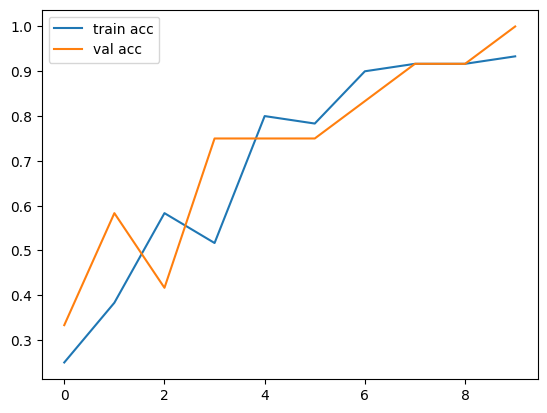

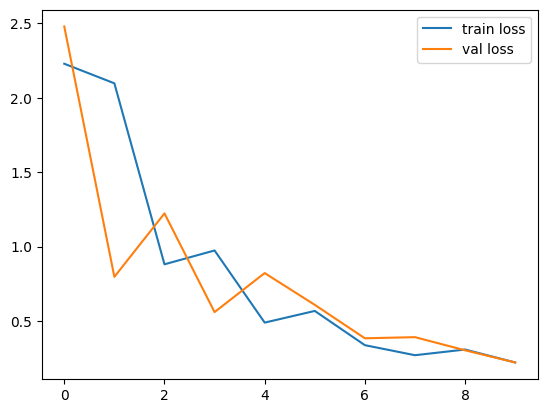

In [11]:
# accuracies

plt.plot(history.history['accuracy'], label='train acc')

plt.plot(history.history['val_accuracy'], label='val acc')

plt.legend()

plt.savefig('vgg-acc-rps-1.png')

plt.show()

# loss
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.savefig('vgg-loss-rps-1.png')
plt.show()

## Model evaluation

In [12]:
model.evaluate(test_x,test_y,batch_size=32)

1/1 [==============================] - 1s 874ms/step - loss: 0.6216 - accuracy: 0.6667


[0.6215707659721375, 0.6666666865348816]

In [13]:
from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
import numpy as np

#predict
y_pred=model.predict(test_x)
y_pred=np.argmax(y_pred,axis=1)
#get classification report
print(classification_report(y_pred,test_y))
#get confusion matrix
print(confusion_matrix(y_pred,test_y))

1/1 [==============================] - 1s 798ms/step
              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       1.00      0.67      0.80         3
           2       0.50      1.00      0.67         1

    accuracy                           0.67         6
   macro avg       0.67      0.72      0.66         6
weighted avg       0.75      0.67      0.68         6

[[1 0 1]
 [1 2 0]
 [0 0 1]]
